# Doppler Broadened Case

### Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.optimize import fsolve
from scipy.linalg import LinAlgError, solve
from scipy.special import erfinv

## Parameters

In [38]:
# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
lambda1 = 795e-9       # In m
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters
z = 0.00005    # Step size in meters

k_b = 1.380649e-23     # Boltzmann constant (m^2 kg s^-2 K^-1)
m = 1.41e-25           # Mass of the particle (kg)
T = 350                # Temperature (K)

if T > (273 + 39.3):
    P = 10**(2.881 + 4.312 - 4040/T)
    
else:
    P = 10**(2.881 + 4.857 - 4215/T)

print("Vapor Pressure: " + str(P))
N = P * 133.32 / (k_b * T)
OD_0 = N*L*(2 * (np.pi)**2 * np.abs(mu_13)**2) / (hbar * epsilon_0 * w_1 * lambda1) * np.sqrt(m * c**2 / (2 * np.pi * k_b * T)) 
print("N_vapor = {:.2e}".format(N))
print("OD of vapor: " + str(OD_0))

coll_rate = N * np.sqrt(8*k_b*T/(np.pi*m)) * 1.11594e-18      # gamma = N * v * sigma
print("Collision rate = {:.2e} MHz".format(coll_rate / 1e6))

Gamma12 = Gamma21 = 2.22e-2    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)

# Thermal velocity standard deviation (Sigma)
sigma = np.sqrt(k_b * T / m)

print(np.sqrt(8*k_b*T/(np.pi*m)))

Vapor Pressure: 4.468305487454383e-05
N_vapor = 1.23e+18
OD of vapor: 33.39763072453825
Collision rate = 4.06e-04 MHz
295.4174631152133


# Maxwell-Boltzmann Distribution

Total area under Maxwellian: 0.9990078668740994


C:\Users\ruben\AppData\Local\Temp\ipykernel_21840\843965116.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]


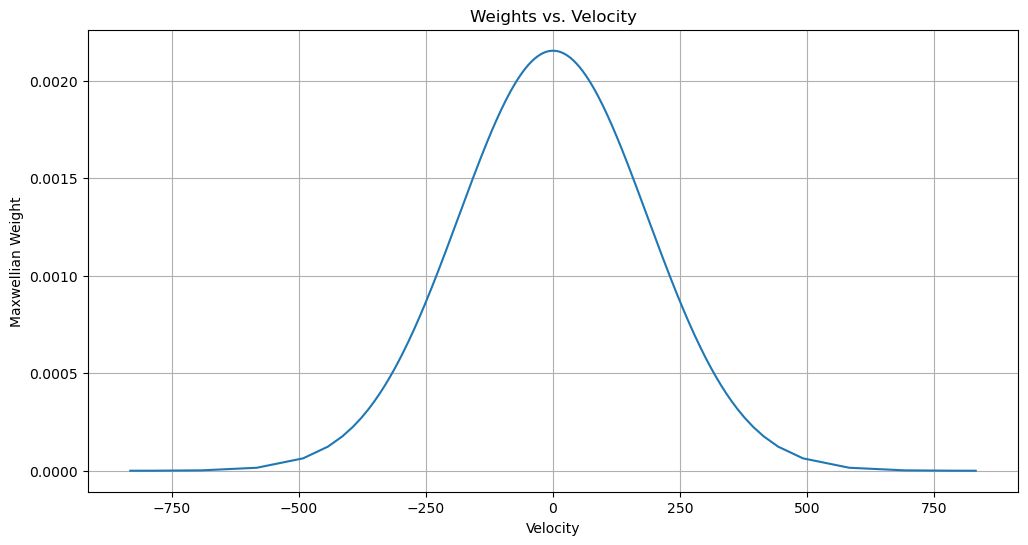

In [25]:
# Maxwell-Boltzmann distribution function
def Maxwellian(V):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-V**2 / (2 * sigma**2))

# Number of velocity points
nv = 251
v_values = np.zeros(nv)
dv = np.zeros(nv)
dv_min = 0.95  # Reduced minimum velocity increment for better resolution

# Middle index (centered at zero velocity)
mid_index = nv // 2
v_values[mid_index] = 0
dv[mid_index] = dv_min * 2

# Area under Maxwellian at zero velocity
area = dv[mid_index] * Maxwellian(0)

# Compute positive velocities
for m in range(mid_index + 1, nv):
    v_end = v_values[m - 1] + dv[m - 1] / 2

    # Define the function to find the root of
    def func(V):
        return Maxwellian((V + v_end) / 2) * (V - v_end) - area

    # Improved initial guess for V
    V_guess = v_end + dv_min

    # Use fsolve to find V such that func(V) = 0
    V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]

    # Update velocity and dv arrays
    v_values[m] = (V_solution + v_end) / 2
    dv[m] = V_solution - v_end

# Reflect to get negative velocities
v_values[:mid_index] = -np.flip(v_values[mid_index + 1:])
dv[:mid_index] = np.flip(dv[mid_index + 1:])

# Maxwell-Boltzmann distribution weights
weights = Maxwellian(v_values)

#print(v_values)
#print(weights)

# Verify that the total area under the curve approximates 1
total_area = np.sum(weights * dv)
print('Total area under Maxwellian:', total_area)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_values, weights)
plt.title('Weights vs. Velocity')
plt.xlabel('Velocity')
plt.ylabel('Maxwellian Weight')
plt.grid(True)
plt.show()

## Main Code

FloatSlider(value=37.0, description='$\\Omega_1$ (MHz)', layout=Layout(width='800px'), max=500.0, min=1e-09, s…

FloatSlider(value=10.0, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, s…

FloatSlider(value=0.0, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, st…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Power required = 8.57e-07 W
Processing z step 50/200
Processing z step 100/200
Processing z step 150/200


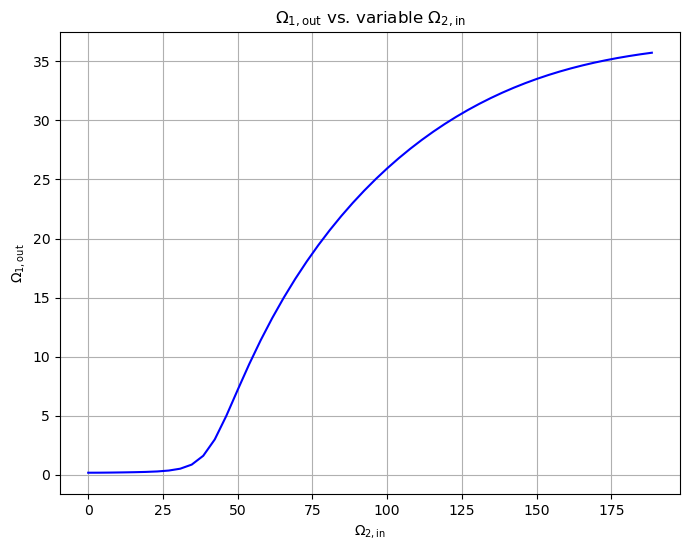

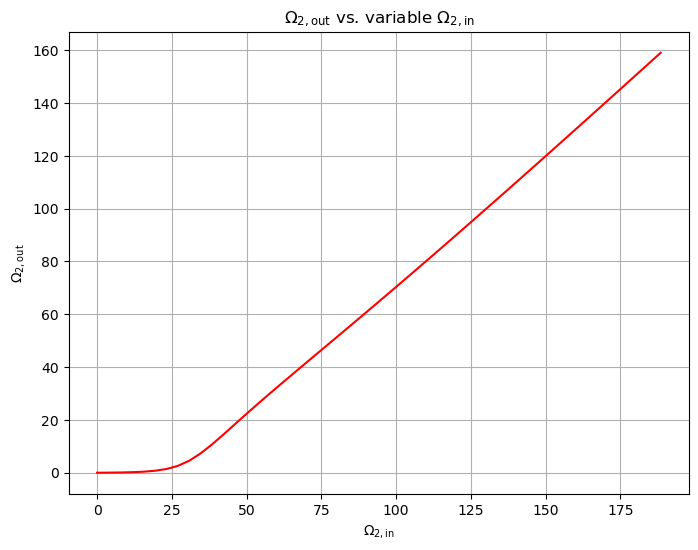

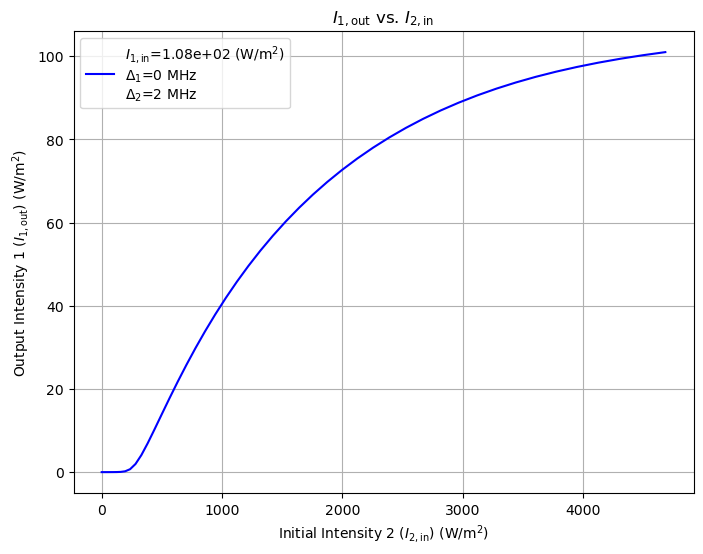

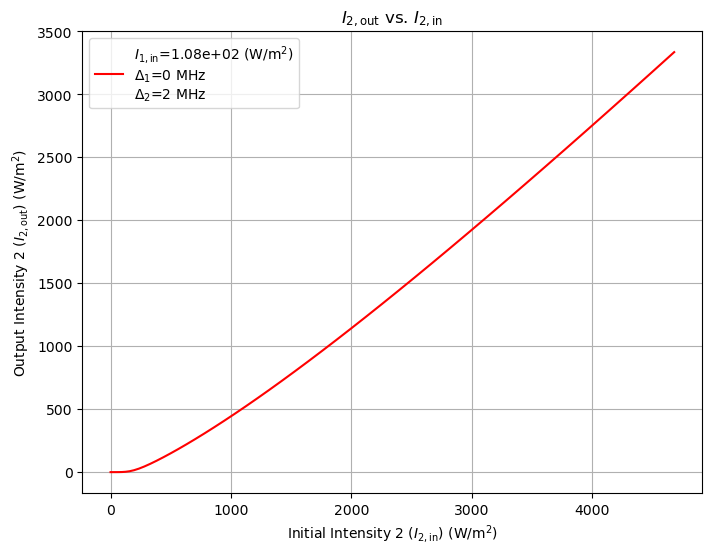

In [10]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 50
    Om_2_list_adapted = np.linspace(0, 5 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted, Om_2_list

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    # Calculate power required for Ω1
    w0 = 71e-6  # Beam waist in meters
    P = (np.pi * c * epsilon_0 * (Om_1 * 1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    print("Power required = {:.2e} W".format(P))
    
    # Calculate the Rabi frequency evolution
    Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted, Om_2_list = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Calculate input intensities
    Input_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (Om_1 * 1e6 * hbar / mu_13)**2
    Input_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (Om_2_list_adapted * 1e6 * hbar / mu_23)**2  
    
    # Calculate output intensities (final z-step) for Ω1 and Ω2
    Output_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :]) * 1e6 * hbar / mu_13)**2
    Output_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :]) * 1e6 * hbar / mu_23)**2  
    
    # --- Plot 1: Final Ω1 vs initial Ω2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted),
             np.abs(Om_1_vs_z[-1, :]),
             color='blue',
             label='Output Intensity $\\Omega_1$')
    plt.xlabel('$\\Omega_{2,\\mathrm{in}}$')
    plt.ylabel('$\\Omega_{1,\\mathrm{out}}$')
    plt.title('$\\Omega_{1,\\mathrm{out}}$ vs. variable $\\Omega_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.show()

    # --- Plot 2: Final Ω2 vs initial Ω2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted),
             np.abs(Om_2_vs_z[-1, :]),
             color='red',
             label='Output Intensity $\\Omega_2$')
    plt.xlabel('$\\Omega_{2,\\mathrm{in}}$')
    plt.ylabel('$\\Omega_{2,\\mathrm{out}}$')
    plt.title('$\\Omega_{2,\\mathrm{out}}$ vs. variable $\\Omega_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.show()
    
    # --- Plot 3: Final I1 vs. initial I2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2,
             Output_Intensity_Omega_1,
             color='blue',
             label=(
                 f'$I_{{1,\\mathrm{{in}}}}$={Input_Intensity_Omega_1:.2e} (W/m$^2$)\n'
                 f'$\\Delta_1$={delta_1} MHz\n'
                 f'$\\Delta_2$={delta_2} MHz'
             ))
    plt.xlabel('Initial Intensity 2 ($I_{2,\\mathrm{in}}$) (W/m$^2$)')
    plt.ylabel('Output Intensity 1 ($I_{1,\\mathrm{out}}$) (W/m$^2$)')
    plt.title('$I_{1,\\mathrm{out}}$ vs. $I_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot 4: Final I2 vs. initial I2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2,
             Output_Intensity_Omega_2,
             color='red',
             label=(
                 f'$I_{{1,\\mathrm{{in}}}}$={Input_Intensity_Omega_1:.2e} (W/m$^2$)\n'
                 f'$\\Delta_1$={delta_1} MHz\n'
                 f'$\\Delta_2$={delta_2} MHz'
             ))
    plt.xlabel('Initial Intensity 2 ($I_{2,\\mathrm{in}}$) (W/m$^2$)')
    plt.ylabel('Output Intensity 2 ($I_{2,\\mathrm{out}}$) (W/m$^2$)')
    plt.title('$I_{2,\\mathrm{out}}$ vs. $I_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_1, delta_1, delta_2 with wider description layout
Om_1_slider = widgets.FloatSlider(
    value=37, min=0.000000001, max=500.0, step=0.01,
    description=r'$\Omega_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=10.0, min=-50, max=150, step=0.01,
    description=r'$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=0.0, min=-50, max=150, step=0.01,
    description=r'$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 37
    delta_1 = 0
    delta_2 = 2
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_1_slider, delta_1_slider, delta_2_slider, run_button)


### Scanning Values

In [39]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 150
    Om_2_list_adapted = np.linspace(0, 8 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    Output_Intensity_Omega_1_list = [0]*len(delta_1)
    Output_Intensity_Omega_2_list = [0]*len(delta_1)
    Input_Intensity_Omega_1_list = [0]*len(delta_1)
    Input_Intensity_Omega_2_list = [0]*len(delta_1)
    Output_Power_Omega_1_list = [0]*len(delta_1)
    Output_Power_Omega_2_list = [0]*len(delta_1)
    Input_Power_Omega_1_list = [0]*len(delta_1)
    Input_Power_Omega_2_list = [0]*len(delta_1)
        
    # Calculate Power of I_1
    w0 = 71e-6          # In m
    P = (np.pi * c * epsilon_0 * (Om_1*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i])
        # Calculate input and output intensity 
        
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
        
        Input_Intensity_Omega_1_list[i] = 0.5 * c * epsilon_0 * (Om_1[i] * 1e6 * hbar / mu_13)**2
        Input_Intensity_Omega_2_list[i] = 0.5 * c * epsilon_0 * (Om_2_list_adapted * 1e6 * hbar / mu_23)**2  
        
        Output_Intensity_Omega_1_list[i] = 0.5 * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :]) * 1e6 * hbar / mu_13)**2
        Output_Intensity_Omega_2_list[i] = 0.5 * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :]) * 1e6 * hbar / mu_23)**2  
        
        Input_Power_Omega_1_list[i] = (np.pi * c * epsilon_0 * (Om_1[i]*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
        Input_Power_Omega_2_list[i] = (np.pi * c * epsilon_0 * (Om_2_list_adapted*1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
        
        Output_Power_Omega_1_list[i] = (np.pi * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :])*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
        Output_Power_Omega_2_list[i] = (np.pi * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :])*1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
        
    #print("Input intensity = {:.2e}".format(Input_Intensity_Omega_1))
    
    ###############
    
    # Plot Transparency of Omega_1 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    for i in range(len(delta_1)):
        plt.plot(np.real(Om_2_list_adapted), Output_Omega_1_list[i]/Om_1[i], label = f'$P_{{1,\\mathrm{{in}}}}={np.abs(Input_Power_Omega_1_list[i]):.1e} \\, \\mathrm{{W}}, \\, \\Delta_2={delta_2[i]:.1f} \\, \\mathrm{{MHz}}$')
    plt.xlabel(r'$\Omega_{2,\mathrm{in}}$ (MHz)')
    plt.ylabel(r'Transparency of $\Omega_{1,\mathrm{out}}$ (MHz)')
    plt.title(r'Transparency of $\Omega_{1,\mathrm{out}}$ vs variable $\Omega_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Omega_2 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    for i in range(len(delta_1)):
        plt.plot(np.real(Om_2_list_adapted), Output_Omega_2_list[i], label = f'$P_{{1,\\mathrm{{in}}}}={np.abs(Input_Power_Omega_1_list[i]):.1e} \\, \\mathrm{{W}}, \\, \\Delta_2={delta_2[i]:.1f} \\, \\mathrm{{MHz}}$')
    plt.xlabel(r'$\Omega_{2,\mathrm{in}}$ (MHz)')
    plt.ylabel(r'$\Omega_{2,\mathrm{out}}$ (MHz)')
    plt.title(r'$\Omega_{2,\mathrm{out}}$ vs variable $\Omega_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    ##############
    
    # Plot Output Transparency Power 1 vs Initial Power 2
    plt.figure(figsize=(8, 6))
    for i in range(len(delta_1)):
        plt.plot(Input_Power_Omega_2_list[i], Output_Power_Omega_1_list[i]/Input_Power_Omega_1_list[i], label = f'$P_{{1,\\mathrm{{in}}}}={np.abs(Input_Power_Omega_1_list[i]):.1e} \\, \\mathrm{{W}}, \\, \\Delta_2={delta_2[i]:.1f} \\, \\mathrm{{MHz}}$')
    plt.xlabel(r'Initial Power 2 ($P_{2,\mathrm{in}}$) $(W)$')
    plt.ylabel(r'Transparency Power 1 ($P_{1,\mathrm{out}}$) $(W)$')
    plt.title(r'Transparency $P_{1,\mathrm{out}}$ vs variable $P_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Output Power 2 vs Initial Power 2
    plt.figure(figsize=(8, 6))
    for i in range(len(delta_1)):
        plt.plot(Input_Power_Omega_2_list[i], Output_Power_Omega_2_list[i], label = f'$P_{{1,\\mathrm{{in}}}}={np.abs(Input_Power_Omega_1_list[i]):.1e} \\, \\mathrm{{W}}, \\, \\Delta_2={delta_2[i]:.1f} \\, \\mathrm{{MHz}}$')
    plt.xlabel(r'Initial Power 2 ($P_{2,\mathrm{in}}$) $(W)$')
    plt.ylabel(r'Output Power 2 ($P_{2,\mathrm{out}}$) $(W)$')
    plt.title(r'$P_{2,\mathrm{out}}$ vs variable $P_{2,\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    ##################
    
    print(np.abs(Om_2_list_adapted).tolist())
    print((np.array(Input_Power_Omega_2_list[0])).tolist())
    print((Output_Omega_1_list).tolist())
    print(Om_1)
    print(Output_Omega_2_list)
    
    print(np.array((Output_Power_Omega_1_list)/np.array(Input_Power_Omega_1_list)).tolist())
    print(Output_Power_Omega_2_list)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([0.5, 1, 1.5, 2])*Gamma3
    delta_1 = [0, 0, 0, 0]
    delta_2 = [1, 4, 8, 15]
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …